# Multi-Objective Optimization

We previously introduced the basic workflow for multi-objective optimization in searching for NRR high-entropy catalysts in [Quick Stark](https://github.com/jchddd/heaict/blob/main/Tutorials/Tutorial%201%20-%20Create%20HEA%20Slab.ipynb), so we will not repeat it here.   

It should be noted that for other tasks, the primary requirement is to customize the problem class. The methods introduced earlier, using extended surfaces to predict activity and stability, as well as predicting the stability of high-entropy catalysts, are all integrated within the relevant problem classes.   

Here, we mainly demonstrate the key considerations when using multi-objective optimization through a simple example.  

Firstly, please note that the multi-objective optimization framework included in this project is a streamlined version. It has removed many features and retains only the core components of a single method. For more optimization algorithms and data type adaptations, please refer to the complete framework, [DGEMO](https://github.com/yunshengtian/DGEMO).  

As previously discussed, executing a multi-objective optimization requires four components: the multi-objective optimization method (**ParetoDiscovery**), the surrogate model (**GPR**), the real-world problem (**Problem**), and the **MOBO** class used to run the final optimization.  

In [1]:
from heaict.mobo.partor_discover import ParetoDiscovery
from heaict.ml.GPR_scikit import GPR
from heaict.mobo.problem import ZDT1
from heaict.mobo.mobo import MOBO

In this framework, the primary tasks involve customizing the problem and selecting the surrogate model.   

For any other research topics, users are required to define their own problem classes (based on the **Problem** class on **heaict.mobo.problem**); here, we use the ZDT1 problem as a demonstration.   

The surrogate model primarily employs Gaussian Process Regression (GPR), for which we provide two implementation methods: one based on scikit-learn (**Data/ml/GPR_scikit**) and another based on gpflow. (**Data/ml/GPR_gpflow**) The scikit-learn version follows the original framework by using analytical solutions to compute gradients, whereas the gpflow version utilizes an automatic gradient solver. Based on our testing, the gpflow-based implementation appears to be more accurate. On the contrary, the scikit-learn-based GPR is more efficient and less likely to throw errors.

# Run Optimization
The parameters that need to be tuned during the multi-objective optimization run are primarily located within the ParetoDiscovery model.   

Detailed parameter information can be found in the reference documentation, while their specific meanings are explained in the related research papers.

In [2]:
ParetoDiscovery?

Init signature:
ParetoDiscovery(
    n_gen=6,
    pop_size=30,
    batch_size=10,
    n_grid_sample=1000,
    perturb_method='origin',
    delta_p=10,
    delta_s=1,
    delta_b=0.2,
    cell_num=100,
    cell_size=10,
    cell_shape='triangle',
    sparse_approx=True,
)
Docstring:     
The Pareto discovery algorithm introduced by: Schulz, Adriana, et al. "Interactive exploration of design trade-offs." ACM Transactions on Graphics (TOG) 37.4 (2018): 1-14.

Method:
    - solve: Use Pareto discovery to suggest points on the Pareto front for the next batch
Init docstring:
Parameters:
    - n_gen (int): number of generations (number of iterations in the pareto front search process). Default = 6
    - pop_size (int): population size (Initial sample quantity). Default = 30
    - batch_size (int): the number of candidate samples collected in pareto discovery each iteration. Default = 10
    - n_grid_sample (int): number of collected samples on local Pareto manifold. Default = 1000
    - pertu

The original ParetoDiscovery code has been modified primarily in two aspects: 
- The first modification involves introducing **Gaussian noise perturbation** to the perturbation method. In the original approach, all x values received a positive increment, which in problems like ZDT1, caused the y values to move away from the optimum to escape local minima. However, this is not necessarily applicable to materials research. For instance, increasing the proportions of the first n-1 elements in a high-entropy alloy simultaneously would be physically unreasonable. Therefore, we adopted simple Gaussian noise for the perturbation.
- The second difference lies in the **sparse sampling procedure**. The original method first removes cells that do not contain samples before applying the graph cut algorithm for sparse sampling. I believed this approach would disrupt the original, perfectly structured connections between buffer cells. Therefore, I implemented sparse sampling without deleting any cells. I am not certain which method yields better results. Additionally, for 3D buffer cells, we have implemented a spherical structure alongside the original triangular structure. Furthermore, you have the option to bypass the graph cut algorithm entirely and instead perform sampling by sequentially selecting samples that maximize the hypervolume. In this case, you do not need to install the pygco library.

Additionally, the kernel of the Gaussian Process Regression and the boundaries of the kernel parameters can also be modified. We have also provided a feature for adaptively selecting the kernel function based on **AIC** or **BIC** scores by setting gp_kernel to a float. It should be noted that this automatic kernel selection is based on the initial samples.   

Therefore, we recommend collecting as many initial samples as possible. This also helps the multi-objective optimization model better understand the potential energy surface distribution across the entire space, leading to a more accurate and converged Pareto front.

We now initialize the three relevant classes.

In [42]:
p = ZDT1()
sm = GPR(real_problem=p, gp_kernel=0.5)
pd = ParetoDiscovery(
    n_gen=6,
    pop_size=10,
    batch_size=10,
    n_grid_sample=1000,
    perturb_method='origin',
    delta_p=10,
    delta_s=1,
    cell_num=100,
    sparse_approx=True
)

Subsequently, the **MOBO** class is used to integrate these three components for execution. At the start of the run, you can either generate random initial data from scratch or specify existing initial data using **X_init** and **Y_init**.  

Additionally, please note that there are two types of Y values in the multi-objective optimization process: the Y values obtained from the real problem and those predicted by the surrogate model. You can determine the final return type via the **return_real** parameter.

Be aware that because the workflow is: get real data -> update model -> sample, the real values from the last sample batch aren't used to update the model. If you want to return the model's Y values, we recommend turning on the **update_final** parameter. This makes the program evaluate the last batch's real values and update the model. This step isn't critical if the model is already converged, but it's necessary if you're checking the model's Y values and the model only just converged in the final iteration.

In [43]:
mobo = MOBO(surrogate_model=sm, algorithm=pd)

In [46]:
X, Y = mobo.optimize(n_init=50, n_iter=3, X_init=None, Y_init=None, update_final=False, return_real=True)

------ Start optimization - [2026-01-05 17:14:05]
Generate 50 initial samples
------ Iteration 1 - [2026-01-05 17:14:05]
Evaluate 50 data points from real problem - [2026-01-05 17:14:05]
Fit surrogate model with 50 data points - [2026-01-05 17:14:05]
initialize surrogate models with kernel: RBF Matern52
Surrogate models constructed successfully - [2026-01-05 17:14:05]
obj 0: r2 1.0000 | mae 0.0000 | rmse 0.0000 | picp 1.0000 | mpiw 0.0000
obj 1: r2 1.0000 | mae 0.0000 | rmse 0.0000 | picp 1.0000 | mpiw 0.0000
--- ParetoDiscovery - [2026-01-05 17:14:05]
generation 1: completed - [2026-01-05 17:14:05]
generation 2: completed - [2026-01-05 17:14:05]
generation 3: completed - [2026-01-05 17:14:05]
generation 4: completed - [2026-01-05 17:14:06]
generation 5: completed - [2026-01-05 17:14:06]
generation 6: completed - [2026-01-05 17:14:06]
Suggest next batch: completed - [2026-01-05 17:14:06]
Add 10 to training set
------ Iteration 2 - [2026-01-05 17:14:06]
Evaluate 10 data points from real

# Result Check
After the run completes, first examine the convergence by checking the hyperparameters.   

You can perform multiple runs and combine the results to obtain the optimal Pareto front. In this case, you can pass a list containing all the Y values into function A to plot the hyperparameter variations across the multiple runs.  

For example, we have repeated the execution of the code above twice, storing the results in Y1 and Y2, respectively.

In [8]:
from heaict.mobo.plot import plot_performance_metric

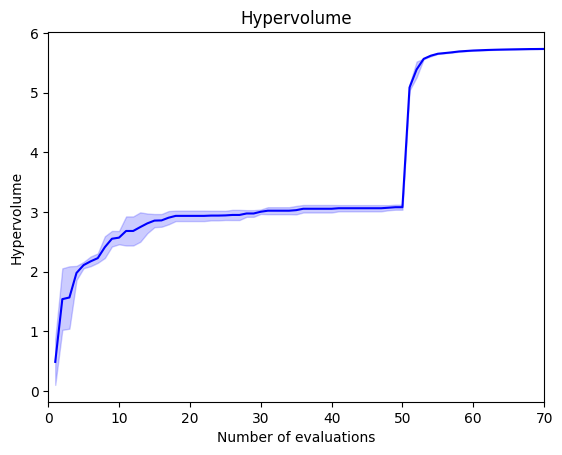

In [49]:
plot_performance_metric(Ys=[Y, Y1, Y2])

As mentioned previously, the Y values consist of both the real values and those predicted by the surrogate model.   

Here, we are returning the real values, while the Pareto front derived from the surrogate model can be obtained from **ParetoDiscovery**. Additionally, regarding convergence performance, the optimization had essentially converged well before the final iteration. Therefore, using the surrogate-based Pareto front without an extra update to the surrogate model should be acceptable.

In [10]:
import matplotlib.pyplot as plt
from heaict.mobo.utility import find_pareto_front

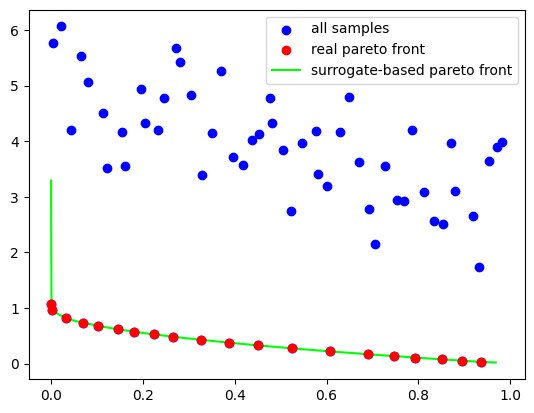

In [48]:
pf, _ = find_pareto_front(Y)
plt.scatter(Y[:, 0], Y[:, 1], label='all samples', zorder=0.5, c='b')
plt.scatter(pf[:, 0], pf[:, 1], label='real pareto front', zorder=1, c='r')
s_pf = mobo.surrogate_model.normalization.undo(Y=mobo.algorithm.pfront)
plt.plot(s_pf[:, 0], s_pf[:, 1], label='surrogate-based pareto front', zorder=0, c='lime')
plt.legend()

Since we have a surrogate model, we can directly visualize the potential energy surface distribution predicted by the model to evaluate whether the shape and location of the obtained Pareto front are reasonable.  

Due to the 10 input dimensions of the ZDT1 problem, evaluating the full energy landscape is memory-intensive and infeasible on the current device. Thus, we used a large sampling interval, producing only a partial surface. However, the plot shows the Pareto front lies where obj2 is small, and obj2 decreases as obj1 increases—consistent with our results.   

For the 5-input case in the paper, an interval of 0.05 provides good results.

In [14]:
from heaict.mobo.plot import grid_search_objectPS

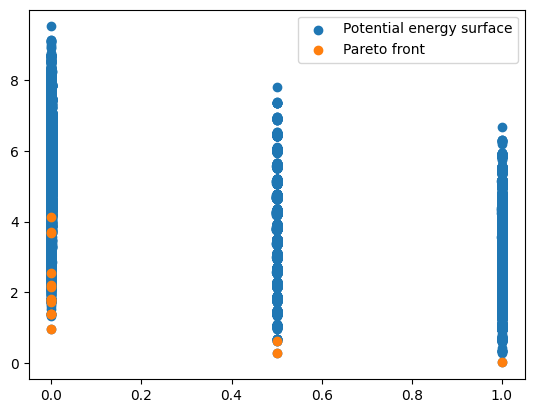

In [47]:
grid_search_objectPS(
    surrogate_model=mobo.surrogate_model,
    interval=0.5
)

We have also provided several functions to visualize the data distribution within the buffer cell space, aiding in a better understanding of the algorithm.   

In the following plots, each red dot represents the center of a cell, while the blue dots indicate the distribution of Pareto front samples within the buffer cell space. Each blue dot is assigned to the cell corresponding to the nearest red dot (cell center).

In [12]:
from heaict.mobo.plot import plot_cell_sample_2D

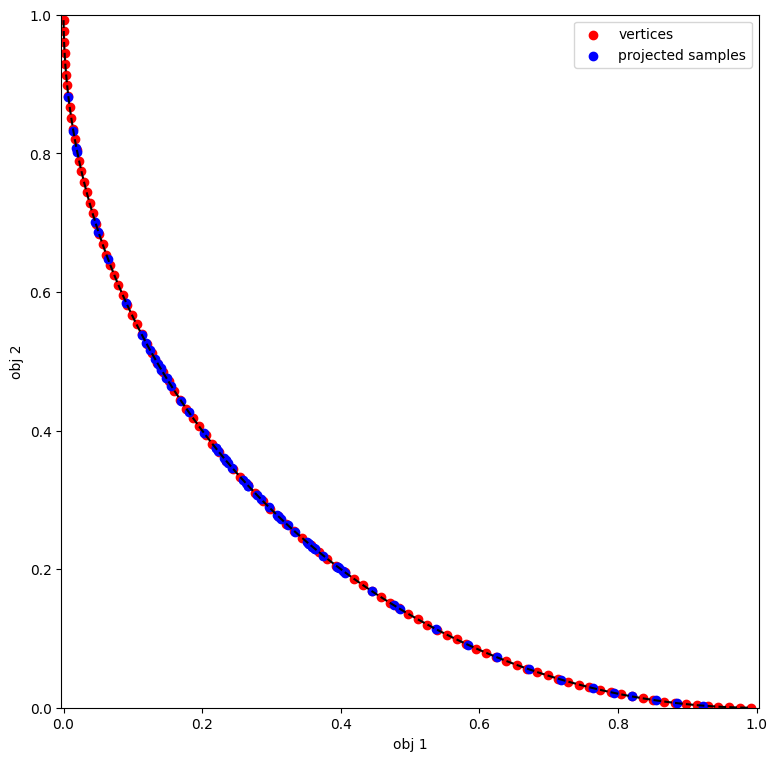

In [50]:
plot_cell_sample_2D(mobo.algorithm.buffer, mobo.surrogate_model.normalization.do(Y=Y))